CNN model inspired by DeepSF model (DOI:10.1145/3233547.3233716)

In [18]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter
from helpers import*

# DeepSF Model 

1. Load the dataset 

In [19]:
#load training data (will be put in a function later)  
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'train_v1.csv',index_col="seq_id")
train_df = train_df.drop(columns=['data_source'])
train_df = train_df.dropna()

# load test data (for submission)
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df = test_df.drop(columns=['data_source'])

train_df.head()

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [20]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protein_sequence'].str.len()
test_df['length'] = test_df['protein_sequence'].str.len()


2. Translate Amino-acids to numbers and create a One-Channel array for each sequence

In [21]:
# fix max_length to be 500
max_length = 500
#drop rows that exceeds this value
train_df = train_df[train_df['length'] < max_length]

In [22]:
# new column with encoded sequence (apply for each sequence)
train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))
test_df['encoded_sequence'] = test_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))

In [23]:
df = train_df.copy()
test_df = test_df.reset_index(drop=True)
df = df.reset_index(drop=True)


3. DeepSF model (CNN)+ MLP 

In [24]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 500

In [25]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df[['pH','length']].values

        # y : the target (tm)
        if train == True : 
            y=df['tm'].values
        else : 
            y = np.zeros(len(sequence))
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]


In [26]:
class DeepSF(nn.Module):

    def __init__(self):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(

            
            nn.Conv1d(20, 10,kernel_size=6, stride=1, padding=3),
            nn.ReLU(),
            

            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            nn.Conv1d(10, 10,kernel_size=6, stride=1, padding=2), 
            nn.ReLU(), 
            
            
         
            torch.nn.MaxPool1d(10), 
            
            torch.nn.Flatten(),
            torch.nn.Dropout(p=0.5, inplace=False),
            
 
            

        )
        self.numerical = nn.Sequential(
            nn.Linear(2, 2),

            
        )
        self.mlp = nn.Sequential(
            nn.Linear(492, 128),#input devrait être 32 + 64 plutôt non si on utilise MaxPoolId(2)? (était marqué 128 en input avant) Comme on fait le pooling
            nn.ReLU(),
 
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x,y):
    
        #deepSF on one_hot encoded sequence x
        x = self.prot_seq_one_pooling(x.float())
       
       # pH and length
        y = self.numerical(y)
       
       #mlp
        x = torch.cat((x.squeeze(1), y), 1)

        x = self.mlp(x)
        return x

4. Cross validation


k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


5. Train model and plot**

In [27]:
train_df , val_df = split_train_test(df,frac=0.8)

train_df has shape : (16408, 5) 
 test_df has shape :  (4102, 5)


In [28]:
# create pytorch datasets
train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

In [29]:
model = DeepSF()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [30]:
# train and test the model (save it after each epoch)
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
#torch.save(model.state_dict(), f"3-Less_Channels.pth")


Test set: Average loss: 1.65e+02 
Test set: Average loss: 1.40e+02 
Test set: Average loss: 1.34e+02 
Test set: Average loss: 1.15e+02 
Test set: Average loss: 1.13e+02 
Test set: Average loss: 1.15e+02 
Test set: Average loss: 1.05e+02 
Test set: Average loss: 1.02e+02 
Test set: Average loss: 1.09e+02 
Test set: Average loss: 1.02e+02 
Test set: Average loss: 9.83e+01 
Test set: Average loss: 9.94e+01 
Test set: Average loss: 9.18e+01 
Test set: Average loss: 9.75e+01 
Test set: Average loss: 9.44e+01 
Test set: Average loss: 9.06e+01 
Test set: Average loss: 9.21e+01 
Test set: Average loss: 9.38e+01 
Test set: Average loss: 9.69e+01 
Test set: Average loss: 8.92e+01 
Test set: Average loss: 9.01e+01 
Test set: Average loss: 9.07e+01 
Test set: Average loss: 8.94e+01 
Test set: Average loss: 8.68e+01 
Test set: Average loss: 8.74e+01 
Test set: Average loss: 8.81e+01 
Test set: Average loss: 8.79e+01 
Test set: Average loss: 8.82e+01 
Test set: Average loss: 8.82e+01 
Test set: Aver

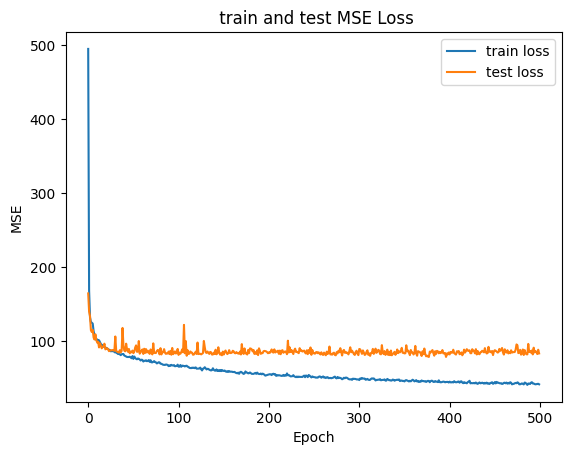

In [31]:
#create loss plot
plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
plt.savefig('4-DeepSF_Loss.png')


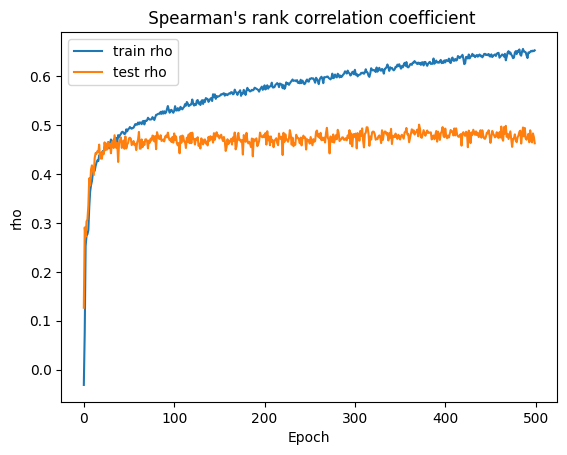

In [32]:
#Spearman's coefficient plot
plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
plt.savefig('4-DeepSF_rho.png')

6. Kaggle Submission

In [33]:
#Prediction for Kaggle's submission
test_d = EnzymesDataset(test_df, False)

# create pytorch dataloaders
sub_dl = torch.utils.data.DataLoader(test_d, batch_size=batch_size, shuffle=True)
submission_df =  predict(model,sub_dl)


In [34]:
submission = pd.read_csv(path+ 'test.csv',index_col='seq_id')
submission['tm']=submission_df
submission = submission.drop(columns=['protein_sequence','pH','data_source'])
#test_sub.to_csv('4-DeepSF.csv', index=True)